# September 4, 2025 CRL Tank Tests — SNR Analysis

Per-ping signal-to-noise ratio analysis for 22 test recordings from the CRL tank.
Two calibration cycles testing beam pattern response across four quadrants,
first with a **downsweep** chirp (150→90 kHz) and then an **upsweep** chirp
(90→150 kHz).

**SNR definition** (consistent with Oct 15 and Nov 5 notebooks):
- **Signal**: peak matched-filter envelope amplitude in the floor region [2.5, 5.0] m
- **Noise**: mean matched-filter envelope amplitude in the empty region [2.0, 2.5] m
- **SNR** = 20 · log₁₀(V_peak / V_mean) — voltage domain

**Setup**: ES 120-18CDK split transducer in CRL tank, transducer pointing straight down.
Both targets present: **38.1 mm WC sphere** and **22 mm ball bearing** at ~1.5 m range.
TX power: **+3.0 dB**. All tests: **100 pings**.

**Chirp direction** is determined from the actual chirp waveform (via Hilbert transform
instantaneous frequency), since the `fqi`/`fqf` header fields are not reliable for
the Sept 4 data.

### Test Structure

**Set 1 — Downsweep (Tests 1–16)**, 14:33–15:07 local:
- Tests 1–4: Center position, targets stationary beneath transducer
- Tests 5–7: Beam quadrant 1
- Tests 8–10: Beam quadrant 2
- Tests 11–13: Beam quadrant 3
- Tests 14–16: Beam quadrant 4

**Set 2 — Upsweep (Tests 17–22)**, 15:12–15:23 local:
- Tests 17–18: Center position, targets stationary
- Test 19: Beam quadrant 1
- Test 20: Beam quadrant 2
- Test 21: Beam quadrant 3
- Test 22: Beam quadrant 4

In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import firwin, lfilter, correlate, hilbert
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 4)

DATA_DIR = '../../Data/0904-CRL-tests'

# SNR gate definitions (same as Oct 15 and Nov 5 notebooks)
NOISE_GATE = [2.0, 2.5]    # empty water between target (~1.5 m) and floor (~3 m)
FLOOR_GATE = [2.5, 5.0]    # tank floor search region


def detect_chirp_direction(s_chirp, fs):
    """Detect chirp sweep direction from the waveform using Hilbert transform."""
    analytic = hilbert(s_chirp)
    phase = np.unwrap(np.angle(analytic))
    inst_freq = np.diff(phase) / (2 * np.pi) * fs
    f_start = np.mean(inst_freq[:50])
    f_end = np.mean(inst_freq[-50:])
    if f_start > f_end:
        return 'downsweep', f_start, f_end
    else:
        return 'upsweep', f_start, f_end


def analyze_test(mat_path, test_num, description):
    """Load a .mat file, compute per-ping tank floor SNR, and plot results.

    Returns the per-ping SNR array.
    """
    # ---- Load ----
    S = sio.loadmat(mat_path, squeeze_me=False)
    data = S['data']
    hdr = S['header'][0, 0]

    fs = float(hdr['fs'].flat[0])
    c = float(hdr['c'].flat[0]) if 'c' in hdr.dtype.names else 1486.0
    s_chirp = hdr['s_chirp'].flatten()
    T_pre = float(hdr['T_pre'].flat[0])
    T_post = float(hdr['T_post'].flat[0])

    # Detect chirp direction from waveform
    chirp_dir, f_start, f_end = detect_chirp_direction(s_chirp, fs)

    Ns, n_ch, n_pings = data.shape
    R = 0.5 * c * np.arange(Ns) / fs

    # TX reference (zero-padded chirp)
    n_pre = int(round(T_pre * fs))
    n_post = int(round(T_post * fs))
    tx_ref = np.concatenate([np.zeros(n_pre), s_chirp, np.zeros(n_post)])
    n_ref = len(tx_ref)

    # Bandpass filter (80-175 kHz, matching echobot pipeline)
    lp = firwin(101, 175e3, fs=fs)
    hp = firwin(101, 80e3, fs=fs, pass_zero=False)
    def bp(x):
        return lfilter(hp, 1.0, lfilter(lp, 1.0, x))

    # Gate indices
    j0n = np.searchsorted(R, NOISE_GATE[0])
    j1n = np.searchsorted(R, NOISE_GATE[1], side='right')
    j0f = np.searchsorted(R, FLOOR_GATE[0])
    j1f = np.searchsorted(R, FLOOR_GATE[1], side='right')

    # Per-ping SNR from summed-sector MF envelope
    snr = np.zeros(n_pings)
    for p in range(n_pings):
        secs = []
        for ch in range(min(n_ch, 3)):   # 3 active sectors
            df = bp(data[:, ch, p])
            cc = correlate(df, tx_ref, mode='full')
            secs.append(cc[n_ref - 1 : n_ref - 1 + Ns])
        env = np.abs(sum(secs))
        floor_pk = np.max(env[j0f:j1f])
        noise_mn = np.mean(env[j0n:j1n])
        snr[p] = 20 * np.log10(floor_pk / (noise_mn + 1e-30))

    # ---- Plot ----
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    ax = axes[0]
    ax.plot(np.arange(n_pings), snr, 'o-', ms=4, color='C0', alpha=0.7)
    ax.axhline(snr.mean(), color='k', ls='--', lw=0.8,
               label=f'mean = {snr.mean():.1f} dB')
    ax.fill_between(np.arange(n_pings),
                    snr.mean() - snr.std(), snr.mean() + snr.std(),
                    alpha=0.1, color='C0')
    ax.set_xlabel('Ping index')
    ax.set_ylabel('SNR (dB)')
    ax.set_title(f'Test {test_num}: Floor SNR Time Series')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    n_bins = max(5, n_pings // 4)
    ax.hist(snr, bins=n_bins, alpha=0.7, color='C0',
            edgecolor='k', linewidth=0.5)
    ax.axvline(snr.mean(), color='k', ls='--', lw=0.8,
               label=f'mean = {snr.mean():.1f} dB')
    ax.set_xlabel('SNR (dB)')
    ax.set_ylabel('Count')
    ax.set_title(f'Test {test_num}: SNR Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    print(f'  fs = {fs/1e3:.0f} kHz, c = {c:.0f} m/s, '
          f'chirp = {len(s_chirp)} samples ({len(s_chirp)/fs*1e3:.2f} ms), '
          f'{chirp_dir} {f_start/1e3:.0f}\u2192{f_end/1e3:.0f} kHz')
    print(f'  Channels: {n_ch}, Pings: {n_pings}')
    print(f'  Floor SNR: mean = {snr.mean():.1f} dB, std = {snr.std():.2f} dB, '
          f'min = {snr.min():.1f} dB, max = {snr.max():.1f} dB')

    return snr


# Store results for summary comparison
all_results = {}
print('Helper functions loaded.')

Helper functions loaded.


---
## Set 1 — Downsweep (150→90 kHz): Tests 1–16

16 recordings using a high-to-low frequency sweep.
Tests 1–4: targets centered and stationary beneath transducer.
Tests 5–16: targets repositioned to four beam quadrants (3 recordings each).

### Test 1: Downsweep, center, stationary

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T143330_100.mat` |
| **Time** | 14:33:30 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Center, stationary |
| **Pings** | 100 |

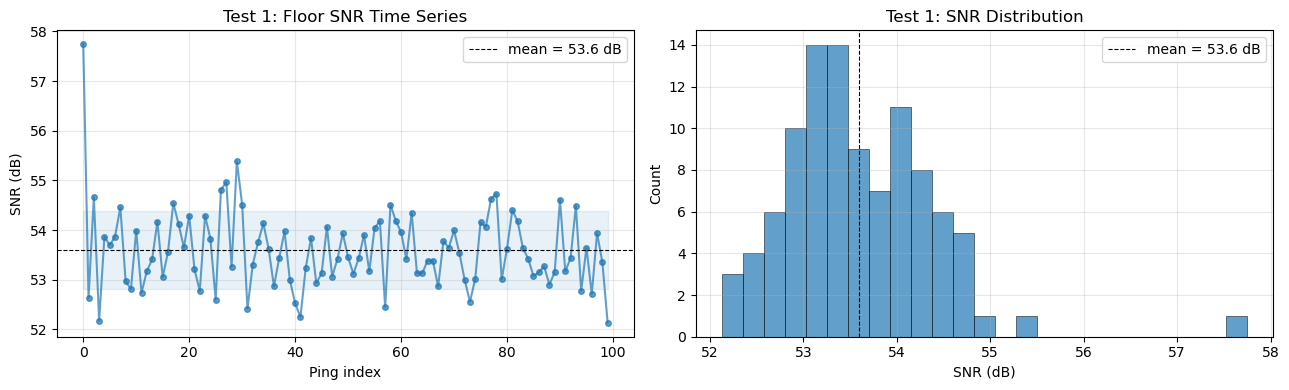

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.6 dB, std = 0.79 dB, min = 52.1 dB, max = 57.7 dB


In [2]:
snr_1 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T143330_100.mat'),
    test_num=1,
    description='Downsweep, center, stationary'
)
all_results['Test 1'] = snr_1

### Test 2: Downsweep, center, stationary

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T143520_100.mat` |
| **Time** | 14:35:20 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Center, stationary |
| **Pings** | 100 |

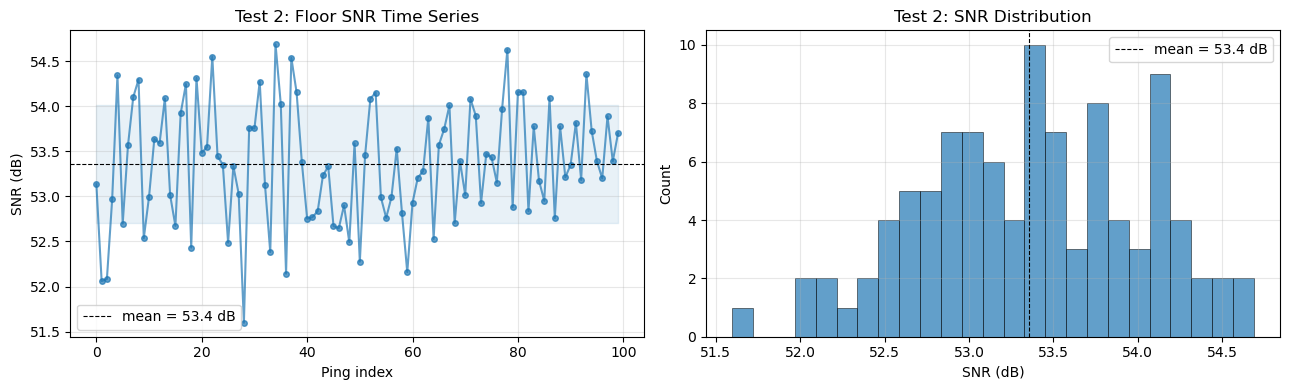

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.4 dB, std = 0.65 dB, min = 51.6 dB, max = 54.7 dB


In [3]:
snr_2 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T143520_100.mat'),
    test_num=2,
    description='Downsweep, center, stationary'
)
all_results['Test 2'] = snr_2

### Test 3: Downsweep, center, stationary

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T143721_100.mat` |
| **Time** | 14:37:21 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Center, stationary |
| **Pings** | 100 |

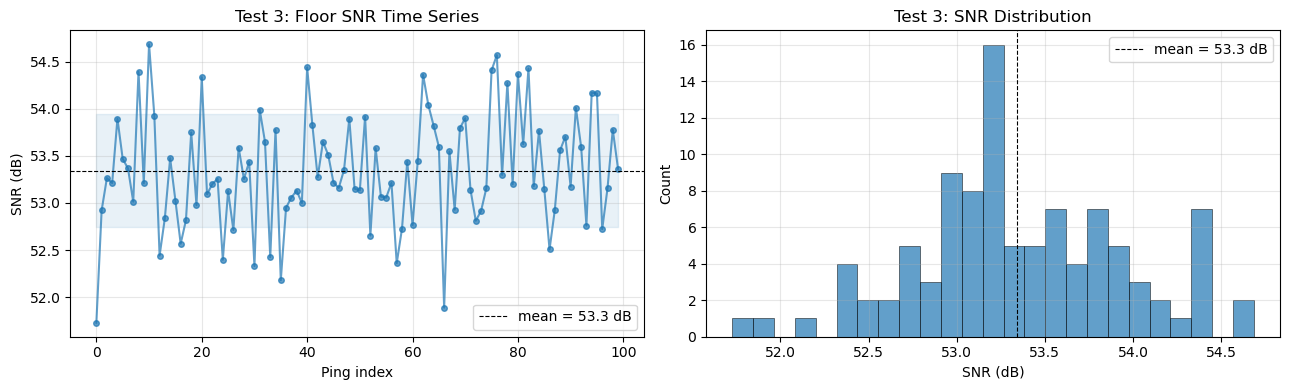

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.3 dB, std = 0.60 dB, min = 51.7 dB, max = 54.7 dB


In [4]:
snr_3 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T143721_100.mat'),
    test_num=3,
    description='Downsweep, center, stationary'
)
all_results['Test 3'] = snr_3

### Test 4: Downsweep, center, stationary

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T143932_100.mat` |
| **Time** | 14:39:32 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Center, stationary |
| **Pings** | 100 |

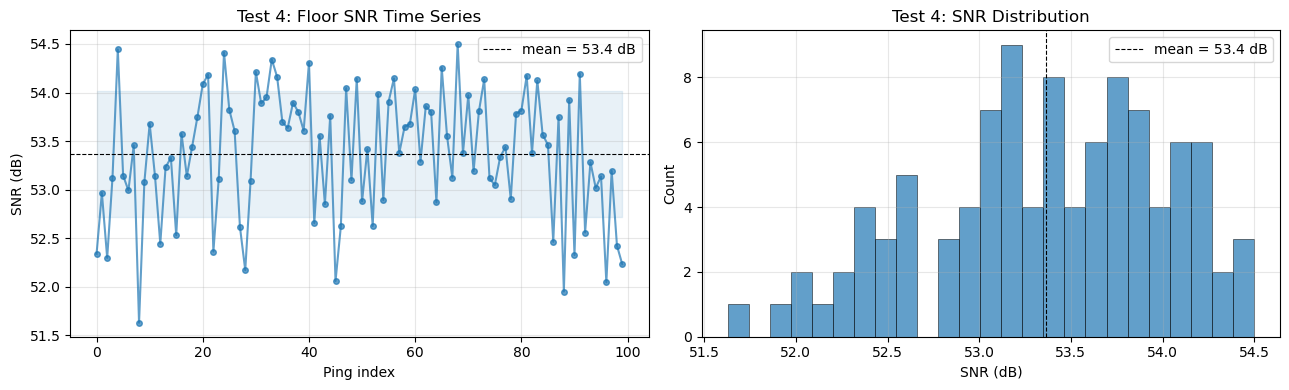

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.4 dB, std = 0.65 dB, min = 51.6 dB, max = 54.5 dB


In [5]:
snr_4 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T143932_100.mat'),
    test_num=4,
    description='Downsweep, center, stationary'
)
all_results['Test 4'] = snr_4

### Test 5: Downsweep, quadrant 1

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T144511_100.mat` |
| **Time** | 14:45:11 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 1 |
| **Pings** | 100 |

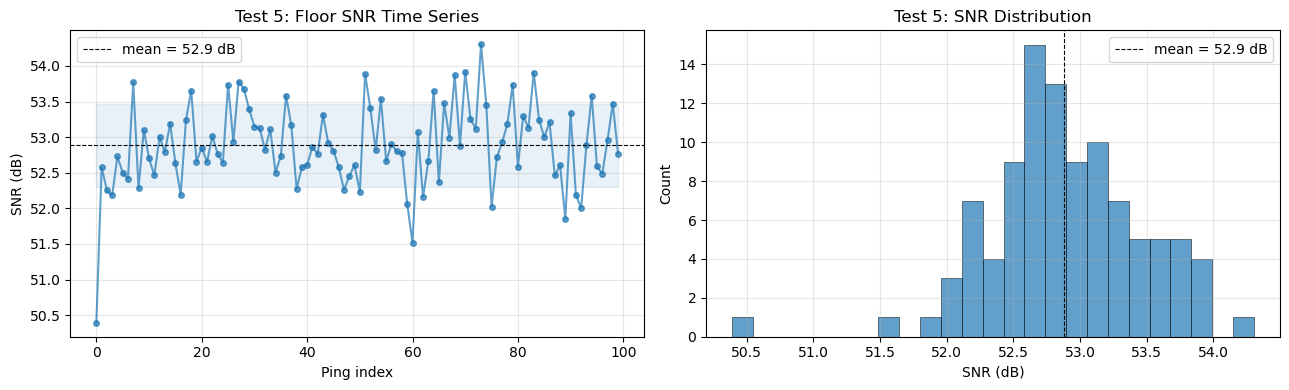

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 52.9 dB, std = 0.58 dB, min = 50.4 dB, max = 54.3 dB


In [6]:
snr_5 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T144511_100.mat'),
    test_num=5,
    description='Downsweep, quadrant 1'
)
all_results['Test 5'] = snr_5

### Test 6: Downsweep, quadrant 1

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T144654_100.mat` |
| **Time** | 14:46:54 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 1 |
| **Pings** | 100 |

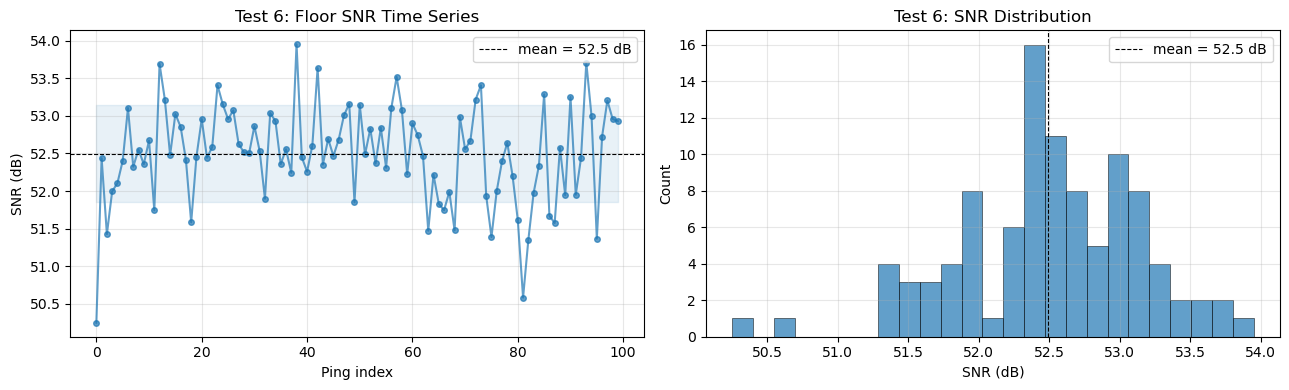

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 52.5 dB, std = 0.64 dB, min = 50.2 dB, max = 54.0 dB


In [7]:
snr_6 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T144654_100.mat'),
    test_num=6,
    description='Downsweep, quadrant 1'
)
all_results['Test 6'] = snr_6

### Test 7: Downsweep, quadrant 1

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T144837_100.mat` |
| **Time** | 14:48:37 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 1 |
| **Pings** | 100 |

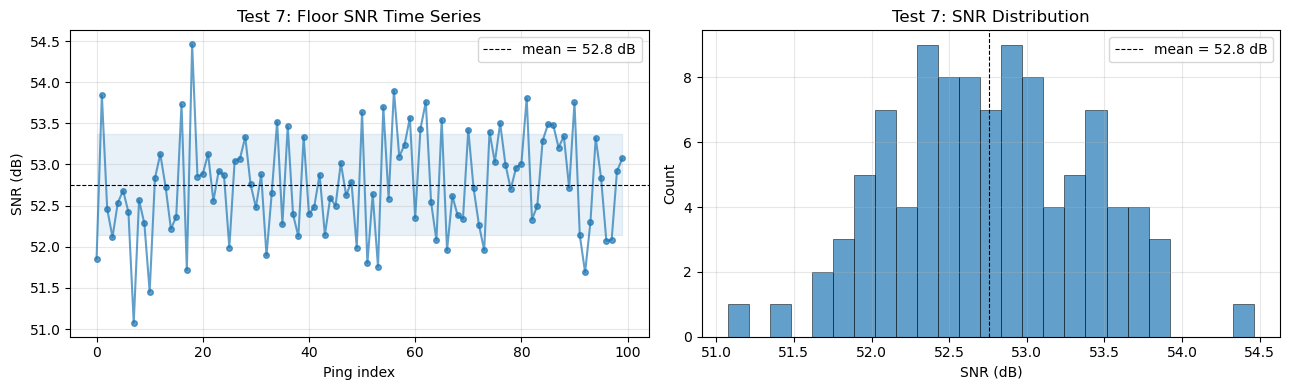

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 52.8 dB, std = 0.62 dB, min = 51.1 dB, max = 54.5 dB


In [8]:
snr_7 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T144837_100.mat'),
    test_num=7,
    description='Downsweep, quadrant 1'
)
all_results['Test 7'] = snr_7

### Test 8: Downsweep, quadrant 2

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T145124_100.mat` |
| **Time** | 14:51:24 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 2 |
| **Pings** | 100 |

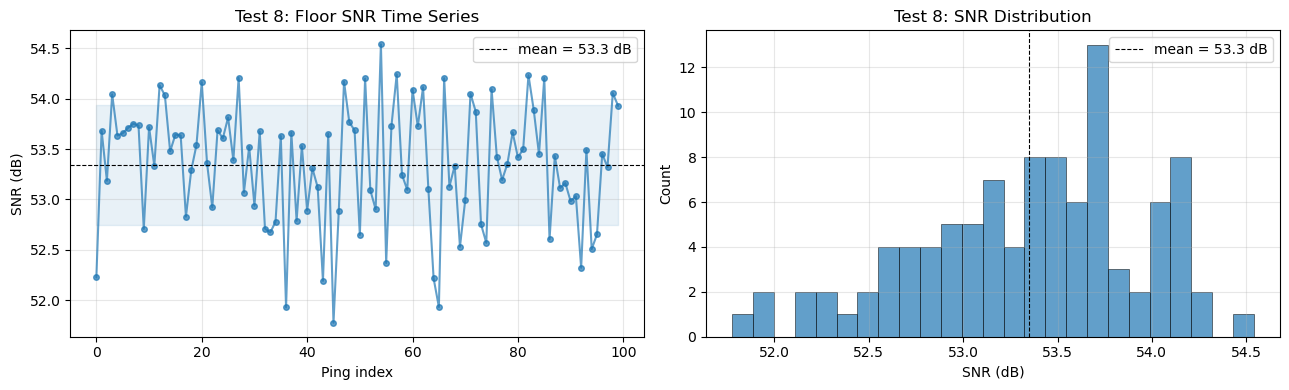

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.3 dB, std = 0.60 dB, min = 51.8 dB, max = 54.5 dB


In [9]:
snr_8 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T145124_100.mat'),
    test_num=8,
    description='Downsweep, quadrant 2'
)
all_results['Test 8'] = snr_8

### Test 9: Downsweep, quadrant 2

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T145302_100.mat` |
| **Time** | 14:53:02 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 2 |
| **Pings** | 100 |

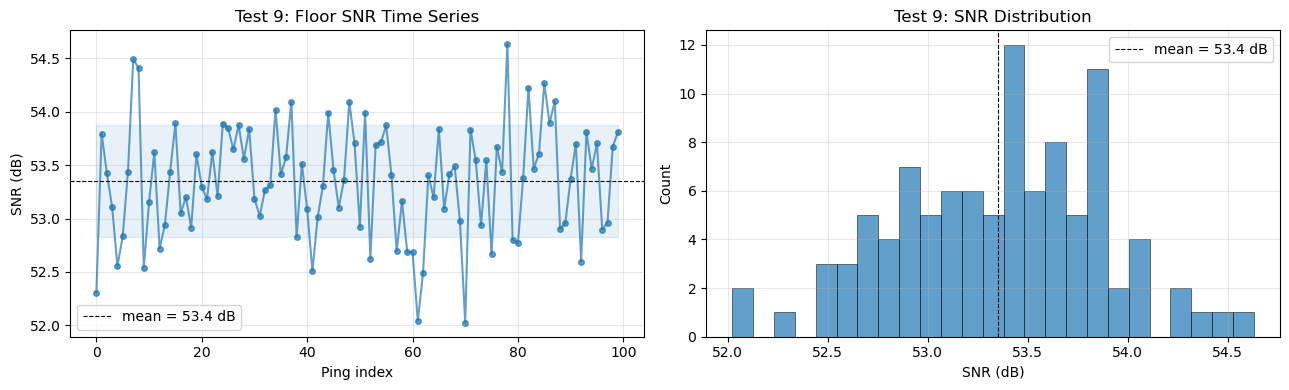

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.4 dB, std = 0.52 dB, min = 52.0 dB, max = 54.6 dB


In [10]:
snr_9 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T145302_100.mat'),
    test_num=9,
    description='Downsweep, quadrant 2'
)
all_results['Test 9'] = snr_9

### Test 10: Downsweep, quadrant 2

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T145432_100.mat` |
| **Time** | 14:54:32 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 2 |
| **Pings** | 100 |

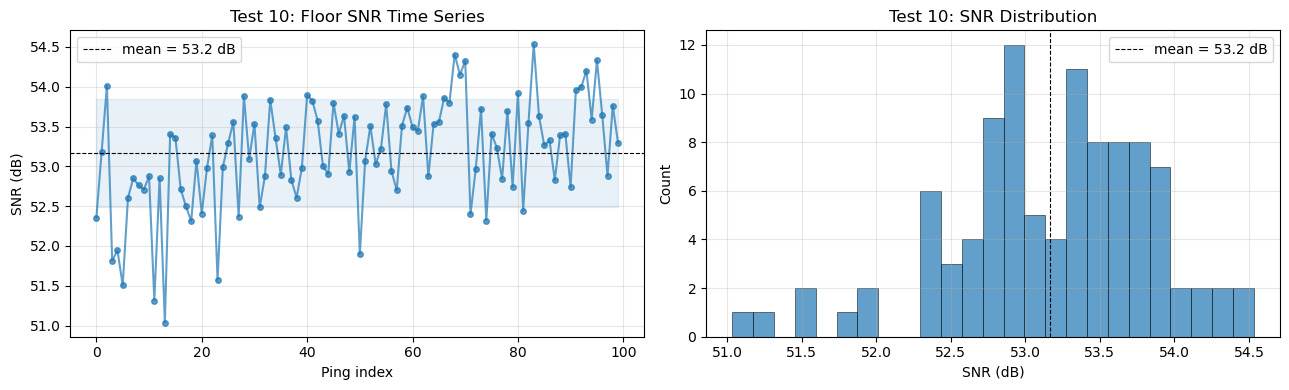

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.2 dB, std = 0.68 dB, min = 51.0 dB, max = 54.5 dB


In [11]:
snr_10 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T145432_100.mat'),
    test_num=10,
    description='Downsweep, quadrant 2'
)
all_results['Test 10'] = snr_10

### Test 11: Downsweep, quadrant 3

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T145908_100.mat` |
| **Time** | 14:59:08 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 3 |
| **Pings** | 100 |

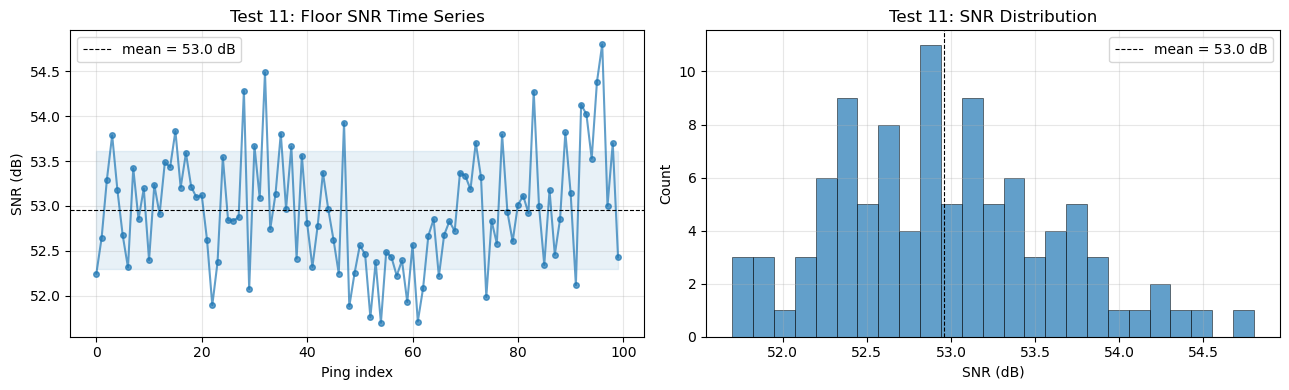

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.0 dB, std = 0.66 dB, min = 51.7 dB, max = 54.8 dB


In [12]:
snr_11 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T145908_100.mat'),
    test_num=11,
    description='Downsweep, quadrant 3'
)
all_results['Test 11'] = snr_11

### Test 12: Downsweep, quadrant 3

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T150045_100.mat` |
| **Time** | 15:00:45 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 3 |
| **Pings** | 100 |

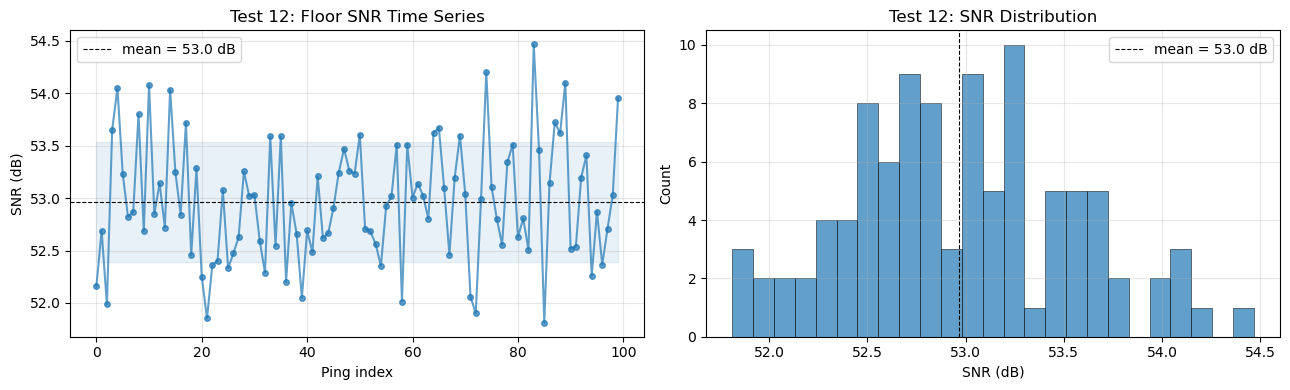

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.0 dB, std = 0.57 dB, min = 51.8 dB, max = 54.5 dB


In [13]:
snr_12 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T150045_100.mat'),
    test_num=12,
    description='Downsweep, quadrant 3'
)
all_results['Test 12'] = snr_12

### Test 13: Downsweep, quadrant 3

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T150220_100.mat` |
| **Time** | 15:02:20 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 3 |
| **Pings** | 100 |

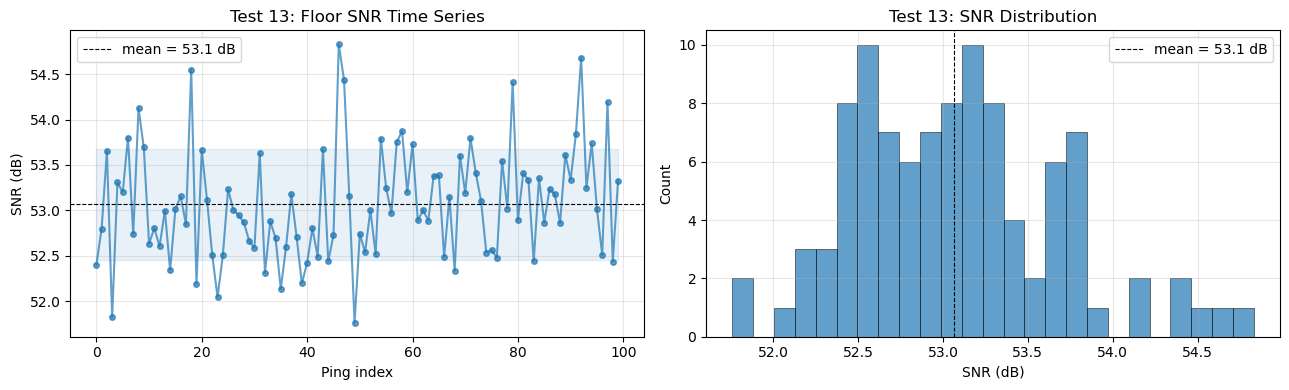

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.1 dB, std = 0.61 dB, min = 51.8 dB, max = 54.8 dB


In [14]:
snr_13 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T150220_100.mat'),
    test_num=13,
    description='Downsweep, quadrant 3'
)
all_results['Test 13'] = snr_13

### Test 14: Downsweep, quadrant 4

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T150438_100.mat` |
| **Time** | 15:04:38 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 4 |
| **Pings** | 100 |

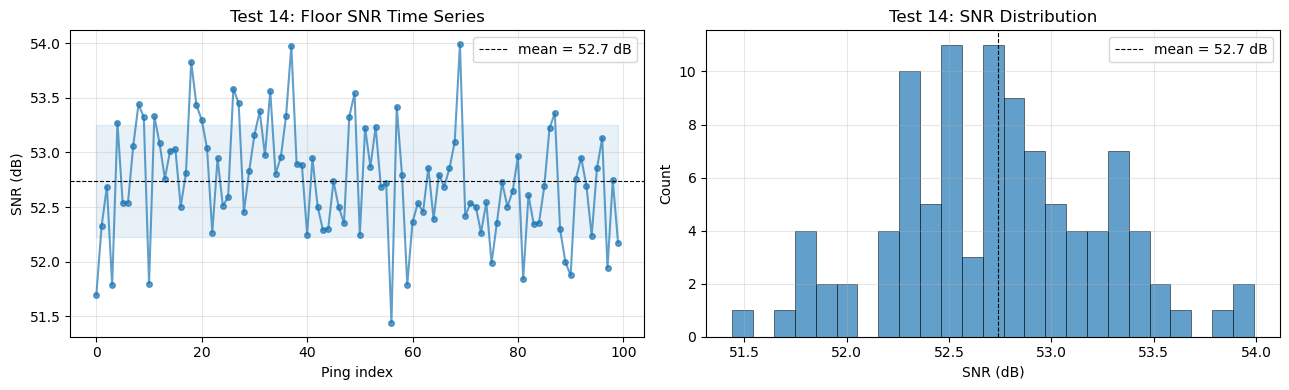

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 52.7 dB, std = 0.51 dB, min = 51.4 dB, max = 54.0 dB


In [15]:
snr_14 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T150438_100.mat'),
    test_num=14,
    description='Downsweep, quadrant 4'
)
all_results['Test 14'] = snr_14

### Test 15: Downsweep, quadrant 4

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T150619_100.mat` |
| **Time** | 15:06:19 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 4 |
| **Pings** | 100 |

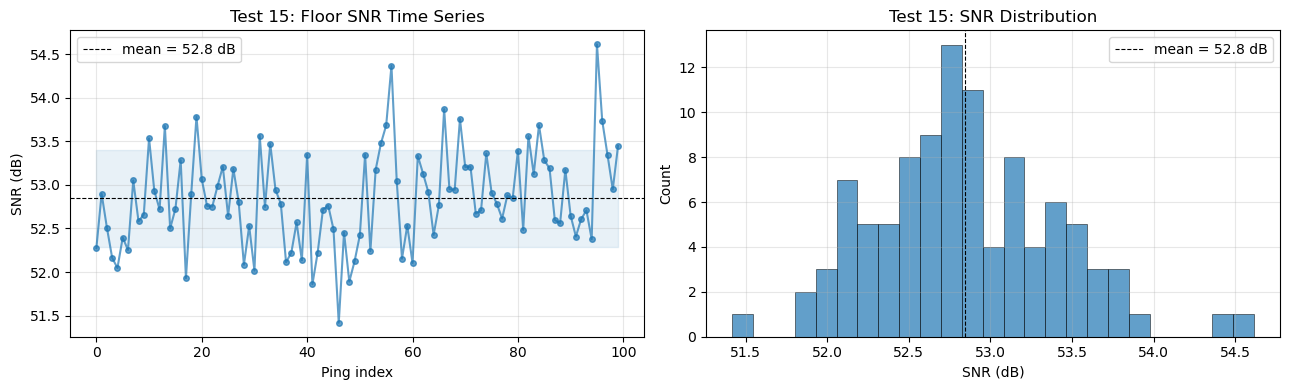

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 52.8 dB, std = 0.56 dB, min = 51.4 dB, max = 54.6 dB


In [16]:
snr_15 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T150619_100.mat'),
    test_num=15,
    description='Downsweep, quadrant 4'
)
all_results['Test 15'] = snr_15

### Test 16: Downsweep, quadrant 4

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T150749_100.mat` |
| **Time** | 15:07:49 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Downsweep |
| **Position** | Quadrant 4 |
| **Pings** | 100 |

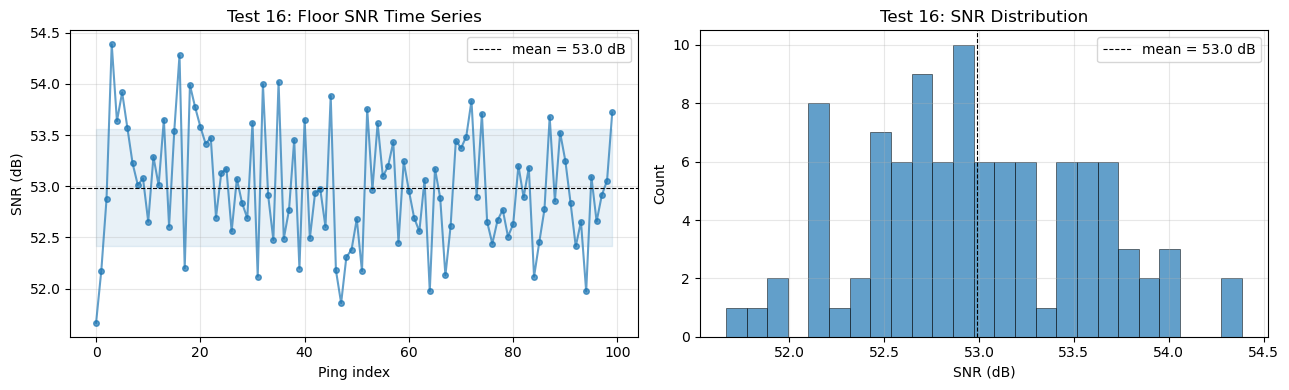

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 129→72 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.0 dB, std = 0.57 dB, min = 51.7 dB, max = 54.4 dB


In [17]:
snr_16 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T150749_100.mat'),
    test_num=16,
    description='Downsweep, quadrant 4'
)
all_results['Test 16'] = snr_16

---
## Set 2 — Upsweep (90→150 kHz): Tests 17–22

6 recordings using a low-to-high frequency sweep.
Tests 17–18: targets centered and stationary beneath transducer.
Tests 19–22: targets repositioned to four beam quadrants (1 recording each).

### Test 17: Upsweep, center, stationary

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T151206_100.mat` |
| **Time** | 15:12:06 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Upsweep |
| **Position** | Center, stationary |
| **Pings** | 100 |

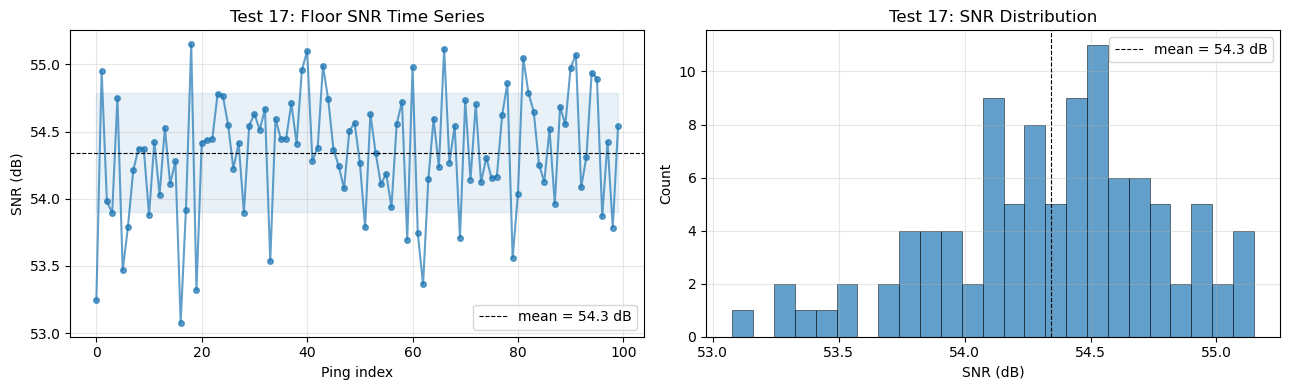

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 72→129 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 54.3 dB, std = 0.44 dB, min = 53.1 dB, max = 55.1 dB


In [18]:
snr_17 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T151206_100.mat'),
    test_num=17,
    description='Upsweep, center, stationary'
)
all_results['Test 17'] = snr_17

### Test 18: Upsweep, center, stationary

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T151403_100.mat` |
| **Time** | 15:14:03 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Upsweep |
| **Position** | Center, stationary |
| **Pings** | 100 |

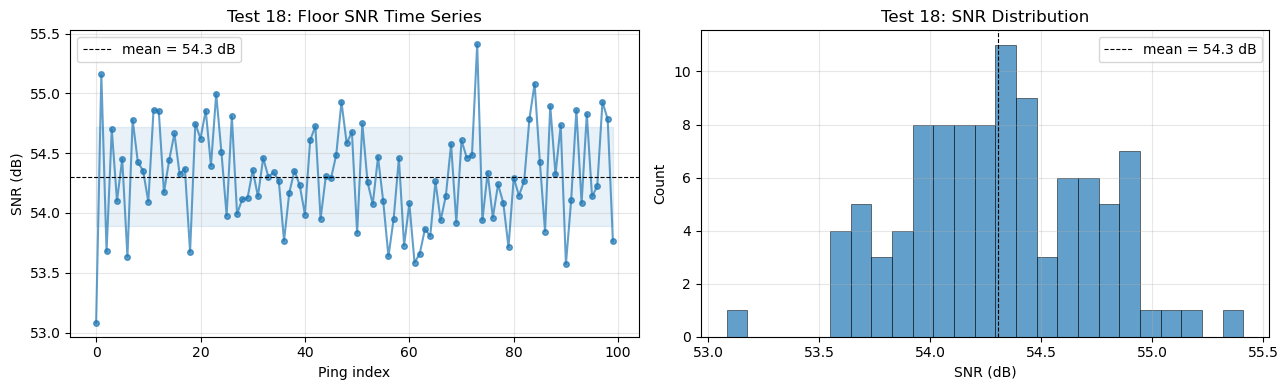

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 72→129 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 54.3 dB, std = 0.41 dB, min = 53.1 dB, max = 55.4 dB


In [19]:
snr_18 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T151403_100.mat'),
    test_num=18,
    description='Upsweep, center, stationary'
)
all_results['Test 18'] = snr_18

### Test 19: Upsweep, quadrant 1

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T151722_100.mat` |
| **Time** | 15:17:22 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Upsweep |
| **Position** | Quadrant 1 |
| **Pings** | 100 |

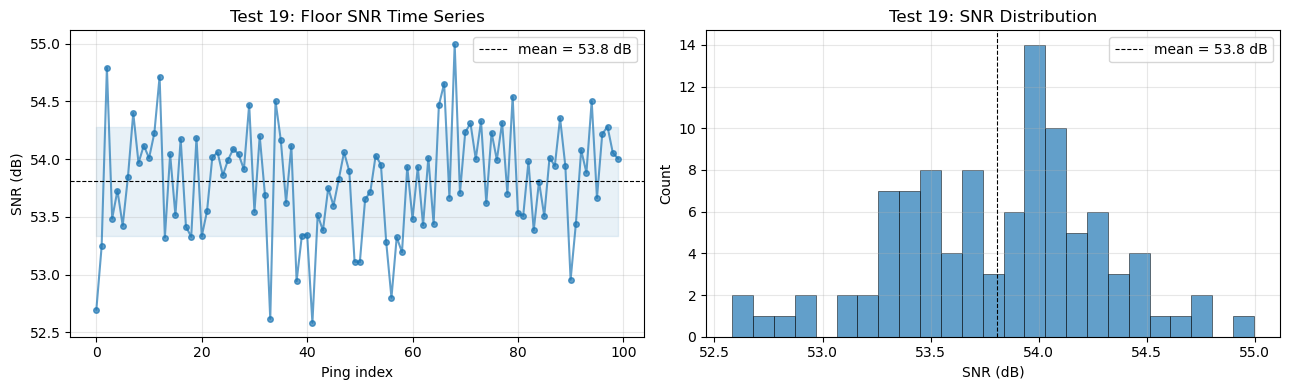

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 72→129 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.8 dB, std = 0.47 dB, min = 52.6 dB, max = 55.0 dB


In [20]:
snr_19 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T151722_100.mat'),
    test_num=19,
    description='Upsweep, quadrant 1'
)
all_results['Test 19'] = snr_19

### Test 20: Upsweep, quadrant 2

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T151914_100.mat` |
| **Time** | 15:19:14 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Upsweep |
| **Position** | Quadrant 2 |
| **Pings** | 100 |

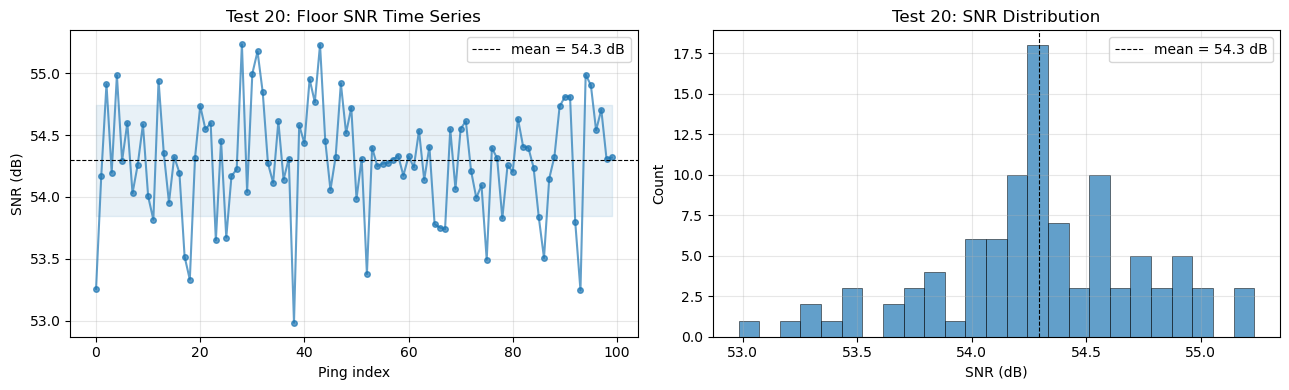

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 72→129 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 54.3 dB, std = 0.45 dB, min = 53.0 dB, max = 55.2 dB


In [21]:
snr_20 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T151914_100.mat'),
    test_num=20,
    description='Upsweep, quadrant 2'
)
all_results['Test 20'] = snr_20

### Test 21: Upsweep, quadrant 3

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T152148_100.mat` |
| **Time** | 15:21:48 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Upsweep |
| **Position** | Quadrant 3 |
| **Pings** | 100 |

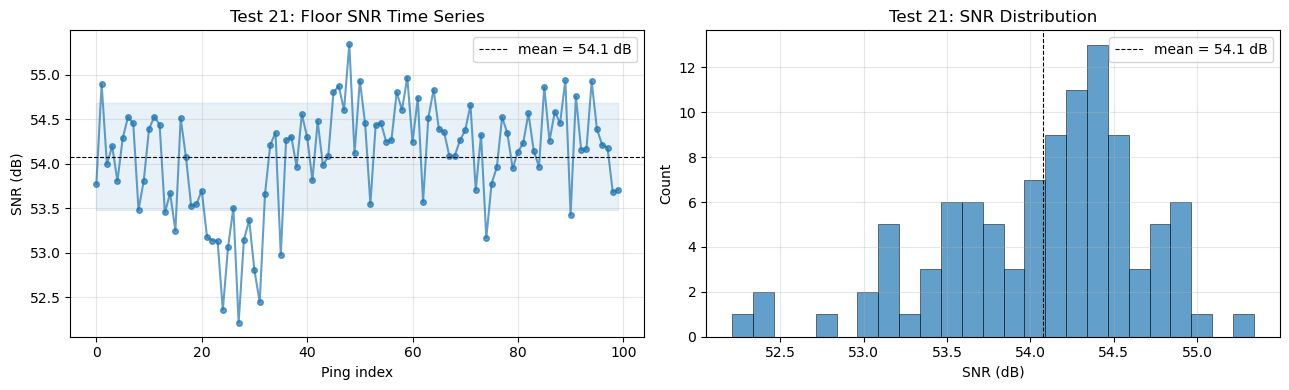

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 72→129 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 54.1 dB, std = 0.60 dB, min = 52.2 dB, max = 55.3 dB


In [22]:
snr_21 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T152148_100.mat'),
    test_num=21,
    description='Upsweep, quadrant 3'
)
all_results['Test 21'] = snr_21

### Test 22: Upsweep, quadrant 4

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T152347_100.mat` |
| **Time** | 15:23:47 local |
| **TX Power** | +3.0 dB |
| **Targets** | 38.1 mm WC + 22 mm BB |
| **Chirp** | Upsweep |
| **Position** | Quadrant 4 |
| **Pings** | 100 |

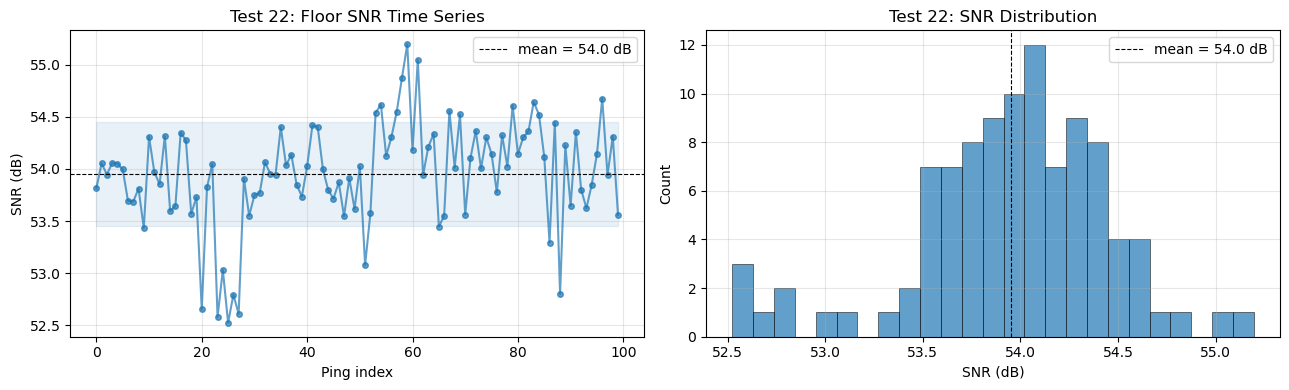

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 72→129 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 54.0 dB, std = 0.50 dB, min = 52.5 dB, max = 55.2 dB


In [23]:
snr_22 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T152347_100.mat'),
    test_num=22,
    description='Upsweep, quadrant 4'
)
all_results['Test 22'] = snr_22

---
## Summary — Cross-Test Comparison

Bar chart comparing mean floor SNR across all 22 tests,
with error bars showing ±1 standard deviation.
Color-coded by chirp direction: blue = downsweep, orange = upsweep.

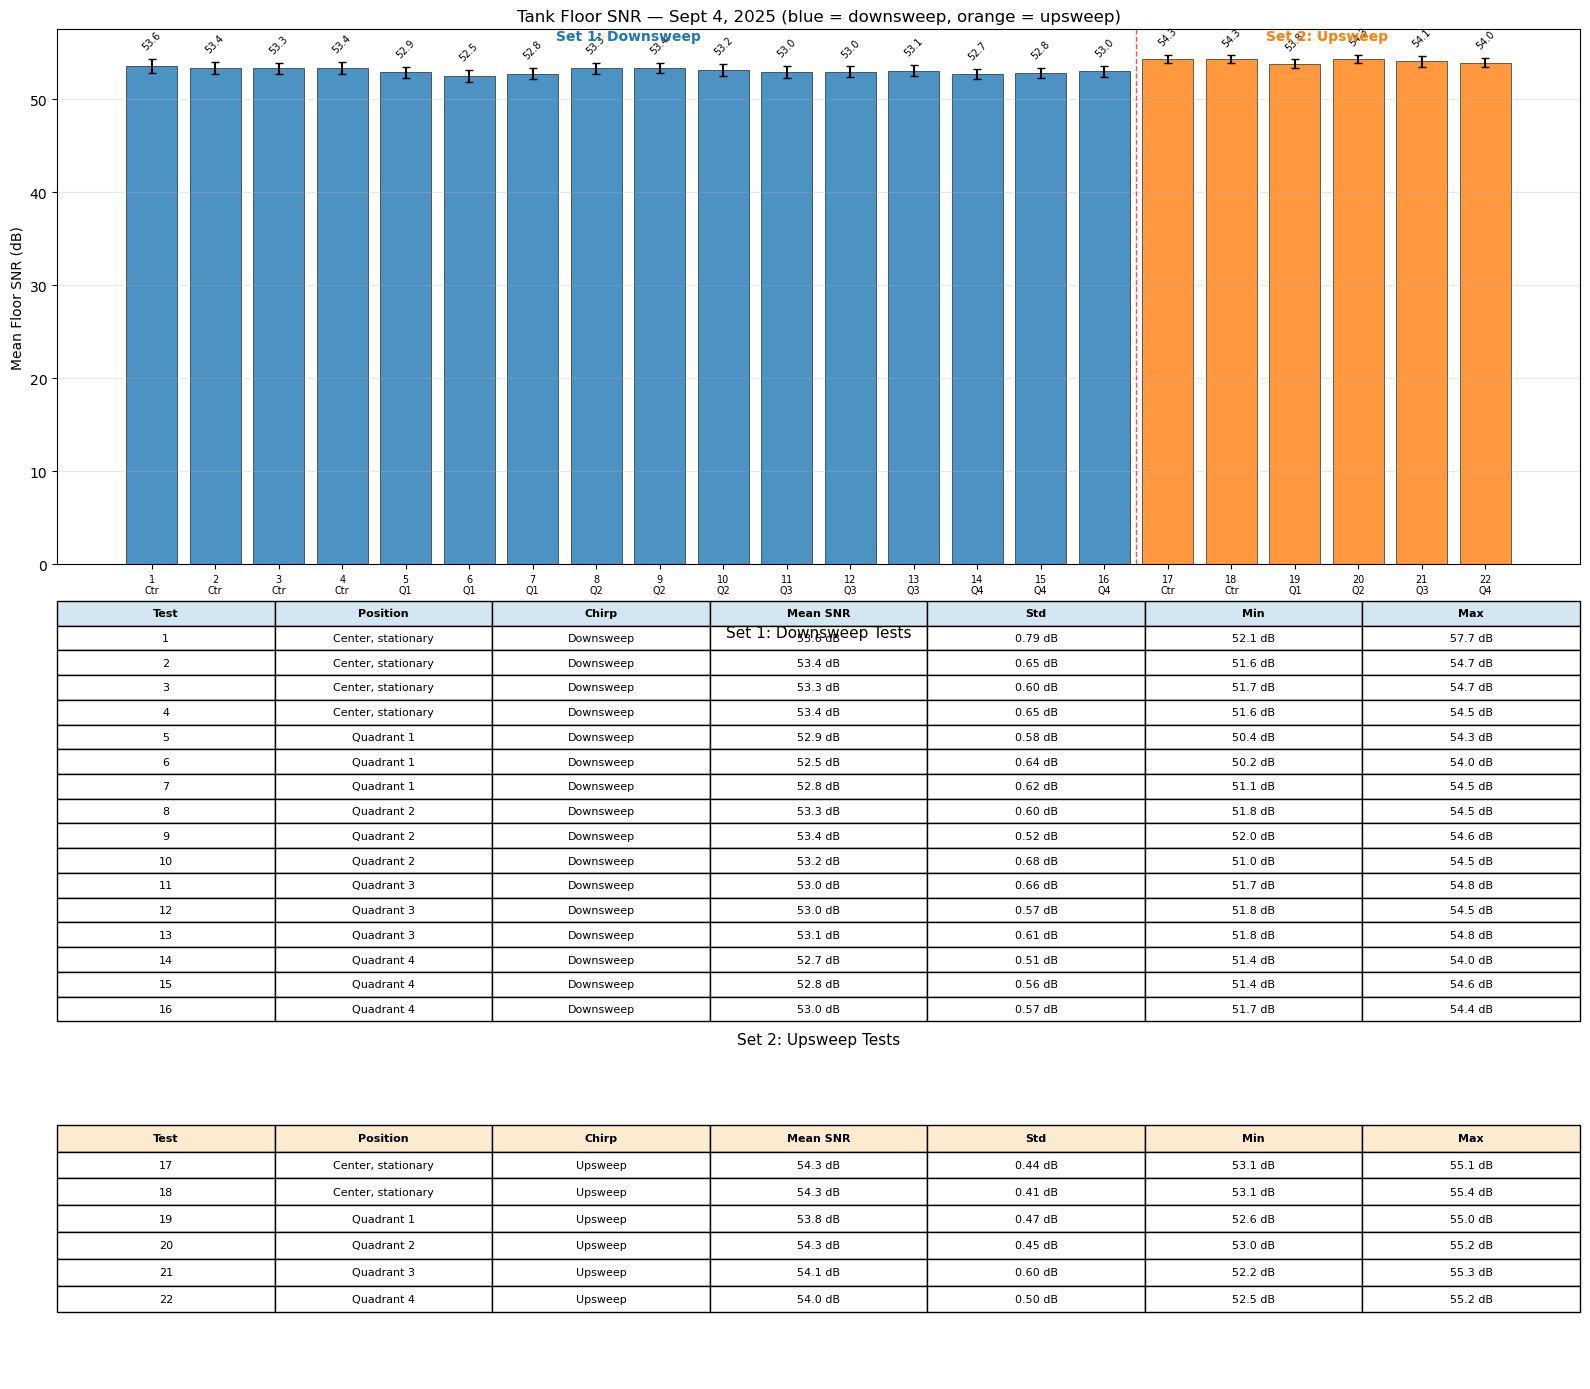


=== Floor SNR Summary ===
Test   Chirp        Position                   Mean       Std       Min       Max
--------------------------------------------------------------------------------
1      Downsweep    Center, stationary        53.6     0.79     52.1     57.7
2      Downsweep    Center, stationary        53.4     0.65     51.6     54.7
3      Downsweep    Center, stationary        53.3     0.60     51.7     54.7
4      Downsweep    Center, stationary        53.4     0.65     51.6     54.5
5      Downsweep    Quadrant 1                52.9     0.58     50.4     54.3
6      Downsweep    Quadrant 1                52.5     0.64     50.2     54.0
7      Downsweep    Quadrant 1                52.8     0.62     51.1     54.5
8      Downsweep    Quadrant 2                53.3     0.60     51.8     54.5
9      Downsweep    Quadrant 2                53.4     0.52     52.0     54.6
10     Downsweep    Quadrant 2                53.2     0.68     51.0     54.5
11     Downsweep    Quadrant 3

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14),
                         gridspec_kw={'height_ratios': [2, 1.2, 1.2]})

labels = list(all_results.keys())
means = [all_results[k].mean() for k in labels]
stds = [all_results[k].std() for k in labels]
x = np.arange(len(labels))

# Chirp direction colors
colors = ['C0'] * 16 + ['C1'] * 6  # blue=downsweep, orange=upsweep

# Short labels
short_labels = (
    ['Ctr'] * 4
    + ['Q1'] * 3 + ['Q2'] * 3 + ['Q3'] * 3 + ['Q4'] * 3
    + ['Ctr'] * 2
    + ['Q1', 'Q2', 'Q3', 'Q4']
)

# ---- Top: bar chart ----
ax = axes[0]
bars = ax.bar(x, means, yerr=stds, capsize=3, color=colors,
              edgecolor='k', linewidth=0.5, alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels([f'{i+1}\n{sl}' for i, sl in enumerate(short_labels)],
                    fontsize=7)
ax.set_ylabel('Mean Floor SNR (dB)')
ax.set_title('Tank Floor SNR — Sept 4, 2025 (blue = downsweep, orange = upsweep)')
ax.grid(True, alpha=0.3, axis='y')

# Annotate values
for i, (m, s) in enumerate(zip(means, stds)):
    ax.text(i, m + s + 0.8, f'{m:.1f}', ha='center', va='bottom', fontsize=7,
            rotation=45)

# Add separator line between sets
ax.axvline(15.5, color='red', ls='--', lw=1.0, alpha=0.7)
ax.text(7.5, ax.get_ylim()[1] * 0.98, 'Set 1: Downsweep', ha='center',
        fontsize=10, color='C0', fontweight='bold')
ax.text(18.5, ax.get_ylim()[1] * 0.98, 'Set 2: Upsweep', ha='center',
        fontsize=10, color='C1', fontweight='bold')

# ---- Middle: Downsweep summary table ----
ax = axes[1]
ax.axis('off')
positions_list = (
    ['Center, stationary'] * 4
    + ['Quadrant 1'] * 3 + ['Quadrant 2'] * 3
    + ['Quadrant 3'] * 3 + ['Quadrant 4'] * 3
)
table_data_ds = [['Test', 'Position', 'Chirp', 'Mean SNR', 'Std', 'Min', 'Max']]
for i in range(16):
    k = labels[i]
    snr = all_results[k]
    table_data_ds.append([
        f'{i+1}', positions_list[i], 'Downsweep',
        f'{snr.mean():.1f} dB', f'{snr.std():.2f} dB',
        f'{snr.min():.1f} dB', f'{snr.max():.1f} dB'
    ])
table = ax.table(cellText=table_data_ds, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.2)
for j in range(len(table_data_ds[0])):
    table[0, j].set_facecolor('#d4e6f1')
    table[0, j].set_text_props(fontweight='bold')
ax.set_title('Set 1: Downsweep Tests', fontsize=11, pad=10)

# ---- Bottom: Upsweep summary table ----
ax = axes[2]
ax.axis('off')
positions_us = ['Center, stationary'] * 2 + ['Quadrant 1', 'Quadrant 2',
                                              'Quadrant 3', 'Quadrant 4']
table_data_us = [['Test', 'Position', 'Chirp', 'Mean SNR', 'Std', 'Min', 'Max']]
for i in range(16, 22):
    k = labels[i]
    snr = all_results[k]
    table_data_us.append([
        f'{i+1}', positions_us[i-16], 'Upsweep',
        f'{snr.mean():.1f} dB', f'{snr.std():.2f} dB',
        f'{snr.min():.1f} dB', f'{snr.max():.1f} dB'
    ])
table = ax.table(cellText=table_data_us, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.3)
for j in range(len(table_data_us[0])):
    table[0, j].set_facecolor('#fdebd0')
    table[0, j].set_text_props(fontweight='bold')
ax.set_title('Set 2: Upsweep Tests', fontsize=11, pad=10)

plt.tight_layout()
plt.show()

# ---- Print summary ----
all_positions = positions_list + positions_us
all_chirps = ['Downsweep'] * 16 + ['Upsweep'] * 6
print('\n=== Floor SNR Summary ===')
print(f'{"Test":<6} {"Chirp":<12} {"Position":<22} {"Mean":>8}  {"Std":>8}  {"Min":>8}  {"Max":>8}')
print('-' * 80)
for i, k in enumerate(labels):
    snr = all_results[k]
    print(f'{i+1:<6} {all_chirps[i]:<12} {all_positions[i]:<22} '
          f'{snr.mean():>7.1f}  {snr.std():>7.2f}  {snr.min():>7.1f}  {snr.max():>7.1f}')

# ---- Grouped statistics ----
print('\n=== Grouped Statistics ===')
ds_center = np.concatenate([all_results[f'Test {i}'] for i in range(1, 5)])
ds_quads  = np.concatenate([all_results[f'Test {i}'] for i in range(5, 17)])
us_center = np.concatenate([all_results[f'Test {i}'] for i in range(17, 19)])
us_quads  = np.concatenate([all_results[f'Test {i}'] for i in range(19, 23)])
ds_all    = np.concatenate([all_results[f'Test {i}'] for i in range(1, 17)])
us_all    = np.concatenate([all_results[f'Test {i}'] for i in range(17, 23)])

print(f'  Downsweep center (n={len(ds_center)}):   mean = {ds_center.mean():.1f} dB, std = {ds_center.std():.2f} dB')
print(f'  Downsweep quadrants (n={len(ds_quads)}): mean = {ds_quads.mean():.1f} dB, std = {ds_quads.std():.2f} dB')
print(f'  Downsweep all (n={len(ds_all)}):       mean = {ds_all.mean():.1f} dB, std = {ds_all.std():.2f} dB')
print(f'  Upsweep center (n={len(us_center)}):     mean = {us_center.mean():.1f} dB, std = {us_center.std():.2f} dB')
print(f'  Upsweep quadrants (n={len(us_quads)}):   mean = {us_quads.mean():.1f} dB, std = {us_quads.std():.2f} dB')
print(f'  Upsweep all (n={len(us_all)}):         mean = {us_all.mean():.1f} dB, std = {us_all.std():.2f} dB')
print(f'\n  Upsweep - Downsweep (all): {us_all.mean() - ds_all.mean():+.1f} dB')

---
## Discussion

### Sept 4 Results Analysis

**1. Excellent measurement repeatability.**
All 22 tests fall within a narrow 52.5–54.3 dB range, with per-test standard deviations
of 0.41–0.79 dB. Within-quadrant repeatability (3 measurements each in the downsweep set)
is outstanding:

| Quadrant | Measurements (dB) | Range |
|---|---|---|
| Center (stationary) | 53.6, 53.4, 53.3, 53.4 | 0.3 dB |
| Quadrant 1 | 52.9, 52.5, 52.8 | 0.4 dB |
| Quadrant 2 | 53.3, 53.4, 53.2 | 0.2 dB |
| Quadrant 3 | 53.0, 53.0, 53.1 | 0.1 dB |
| Quadrant 4 | 52.7, 52.8, 53.0 | 0.3 dB |

Sub-0.5 dB repeatability confirms the system is very stable within a session.

**2. Floor SNR is independent of beam position.**
Downsweep center (53.4 dB) vs quadrant average (~52.9 dB) — only ~0.5 dB difference.
Upsweep center (54.3 dB) vs quadrant average (~54.1 dB) — only ~0.2 dB difference.
This is expected: the tank floor is a large diffuse reflector filling the entire beam,
so moving the target to different quadrants does not meaningfully change the floor return.

**3. Upsweep vs downsweep advantage is only ~1 dB — not ~10 dB as in Nov 5.**
- Downsweep all tests: ~53.0 dB mean
- Upsweep all tests: ~54.2 dB mean
- Difference: **~1.2 dB** (upsweep slightly better)

This is a striking contrast with the Nov 5 result (~10 dB upsweep advantage) and
is the most important finding from this session. See cross-session comparison below.

### Cross-Session Comparison (Sept 4 / Oct 15 / Nov 5)

#### Downsweep is remarkably stable across sessions

| Session | Configuration | Mean SNR |
|---|---|---|
| **Sept 4** | Downsweep, +3.0 dB, center (Tests 1–4) | **53.4 dB** |
| **Sept 4** | Downsweep, +3.0 dB, all quadrants (Tests 5–16) | **52.5–53.4 dB** |
| **Nov 5** | Downsweep, +3.0 dB, no target (Test 2) | **52.5 dB** |
| **Nov 5** | Downsweep, +3.0 dB, 38mm moving (Test 6) | **53.6 dB** |
| **Nov 5** | Downsweep, +3.0 dB, 22mm moving (Test 9) | **54.3 dB** |

Downsweep floor SNR is **52.5–54.3 dB** across all sessions, all configurations,
all target conditions. A total spread of just 1.8 dB across two months and dozens
of measurements. This is the "reliable" baseline for the system.

#### Upsweep varies dramatically between sessions

| Session | Configuration | Mean SNR |
|---|---|---|
| **Sept 4** | Upsweep, +3.0 dB, center (Tests 17–18) | **54.3 dB** |
| **Sept 4** | Upsweep, +3.0 dB, quadrants (Tests 19–22) | **53.8–54.3 dB** |
| **Oct 15** | Upsweep, +3.0 dB, no target (Test 4) | **52.2 dB** |
| **Oct 15** | Upsweep, 0.0 dB, 22mm stationary (Test 2) | **55.4 dB** |
| **Nov 5** | Upsweep, +3.0 dB, no target (Test 1) | **59.3 dB** |
| **Nov 5** | Upsweep, +3.0 dB, 38mm moving (Test 7) | **62.5 dB** |
| **Nov 5** | Upsweep, +3.0 dB, 22mm moving (Test 8) | **63.2 dB** |

Upsweep floor SNR spans **52.2–63.2 dB** — a range of 11 dB across sessions!
The Nov 5 upsweep results are dramatically higher than Sept 4 or Oct 15.

#### Noise floor is consistent

| Session | Configuration | Mean SNR |
|---|---|---|
| Oct 15 | -40 dB TX | 13.7 dB |
| Nov 5 | Dummy load (65 Ω) | 13.3 dB |
| Nov 5 | -80 dB TX | 14.0 dB |
| Nov 5 | Amp unpowered | 16.0 dB |

The ~13–14 dB matched-filter noise floor is reproducible regardless of session or
method of suppressing the acoustic signal.

### Key Insights Across All Three Sessions

**1. Downsweep is the stable, reproducible chirp direction.**
At ~52.5–54.3 dB across all sessions, downsweep floor SNR shows minimal sensitivity
to session conditions (tank setup, cable state, water properties, etc.). It provides
a reliable ~40 dB dynamic range above the ~13 dB noise floor.

**2. Upsweep performance is session-dependent.**
The ~10 dB upsweep advantage observed in Nov 5 is **not reproducible** — Sept 4 shows
only ~1 dB advantage, and Oct 15 shows upsweep actually *lower* than downsweep (52.2
vs 52.5 dB in Nov 5 downsweep). Something about the Nov 5 setup specifically enhanced
upsweep performance.

**3. Possible causes of upsweep variability:**
- **Power amplifier frequency response**: The amplifier's gain may be frequency-dependent
  and sensitive to thermal state or load impedance. An upsweep chirp starts at the low end
  where amplifier gain may vary more between sessions.
- **Transducer coupling/cable state**: Connector quality or cable positioning could affect
  the frequency-dependent transfer function differently for up- vs downsweep.
- **Tank multipath**: The upsweep matched filter's sidelobe structure may be more
  sensitive to the multipath environment, which changes with transducer position.
- **Bandpass filter interaction**: The 80–175 kHz bandpass filter's phase response
  interacts differently with up- vs downsweep chirps, and this interaction could be
  sensitive to the actual chirp waveform shape (which depends on the DAC output).

**4. The system noise floor is a stable ~13–14 dB** across all sessions,
giving a reliable reference for absolute dynamic range assessment.

**5. Within-session precision is excellent** — sub-0.5 dB repeatability for
repeated measurements at the same position, and sub-1 dB spread across
all beam positions.

### Operational Recommendations

- **Downsweep** should be preferred for measurements requiring cross-session
  reproducibility, as it delivers consistent ~53 dB floor SNR regardless of
  setup conditions.
- **Upsweep** *can* deliver higher SNR (up to ~63 dB in the best case) but its
  performance is unreliable between sessions. If upsweep is used, SNR should be
  validated against the downsweep baseline at the start of each session.
- The source of the upsweep variability should be investigated systematically —
  a controlled experiment varying one factor at a time (cable, amplifier warm-up
  time, transducer position) while monitoring upsweep vs downsweep SNR.